# FIQA dataset headline and posts

In [1]:

import pandas as pd
import os
import pysentiment2 as ps
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from pycorenlp import StanfordCoreNLP

In [3]:
df_post = pd.read_json('task1_post_ABSA_train.json').transpose()
#df_head = pd.read_json('task1_headline_ABSA_train.json').transpose()
pd.set_option('display.max_colwidth', 200)
#df
df_post['sentiment_score']=df_post['info'].apply(lambda x:x[0]['sentiment_score'])

#df_head['sentiment_score']=df_head['info'].apply(lambda x:x[0]['sentiment_score'])

df_post

,sentence,info,sentiment_score
14860,Slowly adding some $FIO here but gotta be careful. This will be one of biggest winners in 2012,"[{'snippets': '['Slowly adding some $FIO here but gotta be careful']', 'sentiment_score': '0.459', 'target': 'FIO', 'aspects': '['Stock/Price Action/Bullish/Bull Position']'}]",0.459
14864,$TRX http://stks.co/1KkK Long setup. MACD cross.,"[{'snippets': '['Long setup. MACD cross.']', 'sentiment_score': '0.438', 'target': 'TRX', 'aspects': '['Stock/Technical Analysis']'}]",0.438
14867,I am not optimistic about $amzn both fundementals and charts look like poopoo this quarter.,"[{'snippets': '['both fundementals and charts look like poopoo this quarter.']', 'sentiment_score': '-0.506', 'target': 'AMZN', 'aspects': '['Stock/Price Action/Bearish']'}]",-0.506
14875,$GRPN might be selling off ahead of $P earnings...,"[{'snippets': '['might be selling off ahead']', 'sentiment_score': '-0.202', 'target': 'P', 'aspects': '['Stock/Price Action/Bearish/Bearish Behavior']'}]",-0.202
14876,$IACI http://stks.co/tJU Looks good on the weekly chart.,"[{'snippets': '['Looks good on the weekly chart.']', 'sentiment_score': '0.379', 'target': 'IACI', 'aspects': '['Stock/Technical Analysis']'}]",0.379
...,...,...,...
19130,Facebook $FB received a Buy rating from Wells Fargo 5-star Analyst Peter Stabler (Wells Fargo) https://t.co/jnB4c9vdCu,"[{'snippets': '['received a Buy rating']', 'sentiment_score': '0.456', 'target': 'FB', 'aspects': '['Stock/Coverage/AnalystRatings/Upgrade']'}]",0.456
19149,$TSLA Wish had my puts back but see if we can find support around 243.39 and pop up so that I can get back in. https://t.co/hFkLq3WObV,"[{'snippets': '['if we can find support around 243.39 and pop up']', 'sentiment_score': '-0.485', 'target': 'TSLA', 'aspects': '['Stock/Price Action/Bullish']'}]",-0.485
19161,Citrix Systems Inc $CTXS Position Increased by Mizuho… https://t.co/v7Lkq08Flp @ShareStockNews,"[{'snippets': '['Position Increased by Mizuho']', 'sentiment_score': '0.529', 'target': 'CTXS', 'aspects': '['Stock/Coverage/AnalystRatings/Upgrade']'}]",0.529
19163,"Notable gainers among liquid option names this morning include $STX (+7.0%), $NEM (+4.6%), $WDC (+4.2%), $X (+4.1%), and $GME (+3.4%),","[{'snippets': '['Notable gainers among liquid option names this morning']', 'sentiment_score': '0.513', 'target': 'X', 'aspects': '['Stock/Options']'}]",0.513


In [4]:
def classification(data):
    data['label']='neutral'
    data.loc[data['sentiment_score'].astype(float) < -0.5, 'label'] ='negative'
    data.loc[data['sentiment_score'].astype(float)  > 0.5 ,'label']='positive'
classification(df_post)
#classification(df_head)

In [5]:
def lower_sentence(data):
    data['sentence']=data['sentence'].str.lower()
    data['sentence']=data['sentence'].str.replace("  ",'')
    data['sentence']=data['sentence'].str.replace('[^a-z]',' ', regex=True).str.strip()
lower_sentence(df_post)
#lower_sentence(df_head)

In [6]:
def lm_calculation(data):
    positive_lm=[]
    negative_lm=[]
    lm=ps.LM()
    for i in data['sentence']:
        tokens=lm.tokenize(i)
        positive_lm.append(lm.get_score(tokens)['Positive'])
        negative_lm.append(lm.get_score(tokens)['Negative'])
    data['positive_lm'] =positive_lm
    data['negative_lm'] =negative_lm
   
lm_calculation(df_post)  
#lm_calculation(df_head) 

In [7]:
def lm_classification(data):
    data['classification_lm']='positive'
    data.loc[data['positive_lm'] < data['negative_lm'], 'classification_lm'] ='negative'
    data.loc[data['negative_lm'] == data['positive_lm'],'classification_lm']='neutral'

lm_classification(df_post)    
#lm_classification(df_head) 

In [8]:
def accuracy(data):
    return sklearn.metrics.accuracy_score(data['label'], data['classification_lm'])
print(accuracy(df_post))    
#print(accuracy(df_head))   

0.5333333333333333


In [9]:
def f1_score(data):
    return sklearn.metrics.f1_score(data['label'], data['classification_lm'], average='weighted')
print(f1_score(df_post))
#print(f1_score(df_head))


0.5454380768678999


In [10]:
def confusion_matrix(data):
    return sklearn.metrics.confusion_matrix(data['label'], data['classification_lm'])
confusion_matrix(df_post)
#confusion_matrix(df_head)

array([[ 21,  39,   2],
       [127, 312,  35],
       [ 11, 101,  27]], dtype=int64)

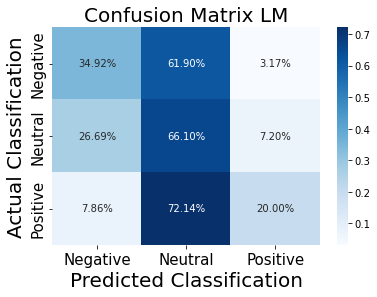

In [41]:
def graph(data):
    confusion_matrix1 =confusion_matrix(data)
    confusion_matrix1=confusion_matrix1.astype('float')/confusion_matrix1.sum(axis=1)[:,np.newaxis]
    ax = sns.heatmap(confusion_matrix1, annot =True, fmt='.2%', cmap='Blues')
    ax.set_title('Confusion Matrix LM',fontsize=20)
    ax.set_xlabel('Predicted Classification',fontsize=20)
    ax.set_ylabel('Actual Classification',fontsize=20)
    ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'],fontsize=15)
    ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'], fontsize=15, va='center')
    plt.savefig('lm_post_final',bbox_inches="tight")
    plt.show()
graph(df_post)
#graph(df_head)

# Harvard Dictionary 

In [13]:
def harvard_calculation(data):
    length=[]
    positive_HIV4=[]
    negative_HIV4=[]
    HIV4=ps.HIV4()
    for i in data['sentence']:
        tokens=HIV4.tokenize(i)
        positive_HIV4.append(HIV4.get_score(tokens)['Positive'])
        negative_HIV4.append(HIV4.get_score(tokens)['Negative'])
    data['positive_HIV4'] =positive_HIV4
    data['negative_HIV4'] =negative_HIV4
    
harvard_calculation(df_post)    
#harvard_calculation(df_head)

NameError: name 'df_head' is not defined

In [14]:
def HIV4_classification(data):
    data['classification_HIV4']='positive'
    data.loc[data['positive_HIV4'] < data['negative_HIV4'], 'classification_HIV4'] ='negative'
    data.loc[data['negative_HIV4'] == data['positive_HIV4'],'classification_HIV4']='neutral'

HIV4_classification(df_post)    
#HIV4_classification(df_head)

In [15]:
def accuracy_HIV4(data):
    return sklearn.metrics.accuracy_score(data['label'], data['classification_HIV4'])
print(accuracy_HIV4(df_post))    
#print(accuracy_HIV4(df_head)) 

0.3940740740740741


In [16]:
def f1_score(data):
    return sklearn.metrics.f1_score(data['label'], data['classification_HIV4'], average='weighted')
print(f1_score(df_post))
#print(f1_score(df_head))


0.4271310887869536


In [17]:
def confusion_matrix_HIV4(data):
    return sklearn.metrics.confusion_matrix(data['label'], data['classification_HIV4'])
confusion_matrix_HIV4(df_post)
#confusion_matrix_HIV4(df_head)

array([[ 19,  30,  13],
       [116, 180, 178],
       [ 15,  57,  67]], dtype=int64)

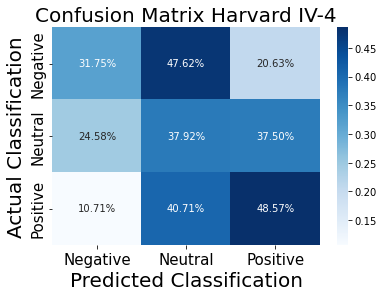

In [40]:
def graph(data):
    confusion_matrix1 =confusion_matrix_HIV4(data)
    confusion_matrix1=confusion_matrix1.astype('float')/confusion_matrix1.sum(axis=1)[:,np.newaxis]
    ax = sns.heatmap(confusion_matrix1, annot =True, fmt='.2%', cmap='Blues')
    ax.set_title('Confusion Matrix Harvard IV-4', fontsize=20)
    ax.set_xlabel('Predicted Classification',fontsize=20)
    ax.set_ylabel('Actual Classification',fontsize=20)
    ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'],fontsize=15)
    ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'], fontsize=15, va='center')
    plt.savefig('harvard_post_final',bbox_inches="tight")
    plt.show()
graph(df_post)
#graph(df_head)

# Finbert

In [20]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

sentences = ["there is a shortage of capital, and we need extra financing",  
             "growth is strong and we have plenty of liquidity", 
             "there are doubts about our finances", 
             "profits are flat"]
results = nlp(sentences)
print(results)  #LABEL_0: neutral; LABEL_1: positive; LABEL_2: negative

[{'label': 'Negative', 'score': 0.9966173768043518}, {'label': 'Positive', 'score': 1.0}, {'label': 'Negative', 'score': 0.9999710321426392}, {'label': 'Neutral', 'score': 0.9889442920684814}]


In [22]:

labels={0:'neutral', 1:'positive',2:'negative'}
def classification_fin(data):
    classification_finbert=[]
    for i in data['sentence']:
        inputs=tokenizer(i, return_tensors='pt', padding=True)
        outputs = finbert(**inputs)[0]
        classification_finbert.append(labels[np.argmax(outputs.detach().numpy())])
    data['classification_finbert']=classification_finbert
classification_fin(df_post)
#classification_fin(df_head)

In [23]:
def accuracy_fin(data):
    return sklearn.metrics.accuracy_score(data['label'], data['classification_finbert'])
print(accuracy_fin(df_post))    
#print(accuracy_fin(df_head))  

0.5748148148148148


In [24]:
def f1_score(data):
    return sklearn.metrics.f1_score(data['label'], data['classification_finbert'], average='weighted')
print(f1_score(df_post))
#print(f1_score(df_head))

0.586589373404338


In [25]:
def confusion_matrix_fin(data):
    return sklearn.metrics.confusion_matrix(data['label'], data['classification_finbert'])
confusion_matrix_fin(df_post)
#confusion_matrix_fin(df_head)

array([[ 22,  38,   2],
       [ 62, 310, 102],
       [  2,  81,  56]], dtype=int64)

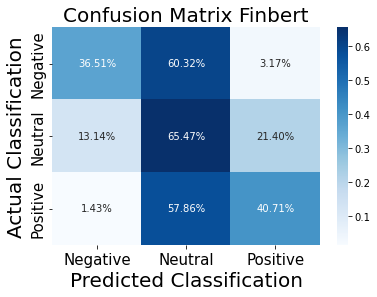

In [38]:
def graph(data):
    confusion_matrix1 =confusion_matrix_fin(data)
    confusion_matrix1=confusion_matrix1.astype('float')/confusion_matrix1.sum(axis=1)[:,np.newaxis]
    ax = sns.heatmap(confusion_matrix1, annot =True, fmt='.2%', cmap='Blues')
    ax.set_title('Confusion Matrix Finbert', fontsize=20)
    ax.set_xlabel('Predicted Classification',fontsize=20)
    ax.set_ylabel('Actual Classification',fontsize=20)
    ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'],fontsize=15)
    ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'], fontsize=15, va='center')
    plt.savefig('fin_post_final',bbox_inches="tight")
    plt.show()
#graph(df_head)
graph(df_post)

# stanford core nlp

In [27]:
os.chdir('C:/Program Files/Java/jre1.8.0_331/bin')

In [28]:
DPATH="C:/Users/Mia/Downloads/stanford-corenlp-4.4.0"
!java -mx6g -cp "$DPATH/*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -timeout 5000

[main] INFO CoreNLP - --- StanfordCoreNLPServer#main() called ---
[main] INFO CoreNLP - Server default properties:
			(Note: unspecified annotator properties are English defaults)
			inputFormat = text
			outputFormat = json
			prettyPrint = false
[main] INFO CoreNLP - Threads: 8
[main] INFO CoreNLP - Starting server...
[main] WARN CoreNLP - java.net.BindException: Address already in use: bind
  sun.nio.ch.Net.bind0(Native Method)
  sun.nio.ch.Net.bind(Unknown Source)
  sun.nio.ch.Net.bind(Unknown Source)
  sun.nio.ch.ServerSocketChannelImpl.bind(Unknown Source)
  sun.nio.ch.ServerSocketAdaptor.bind(Unknown Source)
  sun.net.httpserver.ServerImpl.<init>(Unknown Source)
  sun.net.httpserver.HttpServerImpl.<init>(Unknown Source)
  sun.net.httpserver.DefaultHttpServerProvider.createHttpServer(Unknown Source)
  com.sun.net.httpserver.HttpServer.create(Unknown Source)
  edu.stanford.nlp.pipeline.StanfordCoreNLPServer.run(StanfordCoreNLPServer.java:1534)
  edu.stanford.nlp.pipeline.StanfordC

In [29]:
nlp = StanfordCoreNLP('http://localhost:9000')

In [30]:
def RNN_classification(data):
    classification_RNN=[]
    for i in data['sentence']:
            result= nlp.annotate(i,
                                properties={'annotators': 'sentiment',
                                           'outputFormat':'json','timeout':40000})
            classification_RNN.append(result['sentences'][0]['sentiment'])
    data['classification_RNN']=classification_RNN
    data['classification_RNN']=data['classification_RNN'].str.lower()
RNN_classification(df_post)
#RNN_classification(df_head)

In [32]:
df_post['classification_RNN'].unique()
#df_head['classification_RNN'].unique()
df_post.loc[(df_post['classification_RNN'] == 'verypositive')] = 'positive'
df_post.loc[(df_post['classification_RNN'] == 'verynegative')] = 'negative'
#df_head.loc[(df_head['classification_RNN'] == 'verynegative')] = 'negative'


In [33]:
def accuracy_RNN(data):
    return sklearn.metrics.accuracy_score(data['label'], data['classification_RNN'])
print(accuracy_RNN(df_post))    
#print(accuracy_RNN(df_head))   

0.4962962962962963


In [34]:
def f1_score(data):
    return sklearn.metrics.f1_score(data['label'], data['classification_RNN'], average='weighted')
print(f1_score(df_post))
#print(f1_score(df_head))

0.5174097169004229


In [35]:
def confusion_matrix_rnn(data):
    return sklearn.metrics.confusion_matrix(data['label'], data['classification_RNN'])
confusion_matrix_rnn(df_post)
#confusion_matrix_rnn(df_head)


array([[ 27,  35,   1],
       [110, 279,  83],
       [ 25,  86,  29]], dtype=int64)

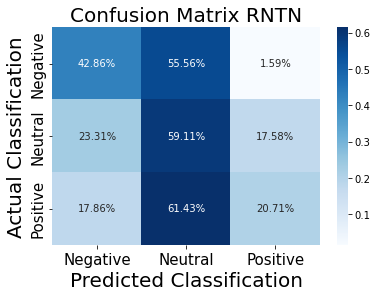

In [37]:
import os
os.chdir('C:/Users/Mia/Downloads')
def graph(data):
    confusion_matrix1 =confusion_matrix_rnn(data)
    confusion_matrix1=confusion_matrix1.astype('float')/confusion_matrix1.sum(axis=1)[:,np.newaxis]
    ax = sns.heatmap(confusion_matrix1, annot =True, fmt='.2%', cmap='Blues')
    ax.set_title('Confusion Matrix RNTN', fontsize=20)
    ax.set_xlabel('Predicted Classification',fontsize=20)
    ax.set_ylabel('Actual Classification',fontsize=20)
    ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'],fontsize=15)
    ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'], fontsize=15, va='center')
    
    plt.savefig('RNTN_post_final', bbox_inches="tight")
    plt.show()
graph(df_post)
#graph(df_head)

In [40]:
df_head
contain_values = df_head[df_head['label'].str.contains('neg')]
contain_values = contain_values[contain_values['classification_finbert'].str.contains('neg')]
contain_values

,sentence,info,sentiment_score,label,positive_lm,negative_lm,classification_lm,positive_HIV4,negative_HIV4,classification_HIV4,classification_finbert,classification_RNN
100,slump in weir leads ftse down from record high,"[{'snippets': '['down from record high']', 'target': 'Weir', 'sentiment_score': '-0.827', 'aspects': '['Market/Volatility/Volatility']'}]",-0.827,negative,1,0,positive,1,1,neutral,negative,negative
116,meggitt share price tumbles as profit falls in challenging year,"[{'snippets': '['tumbles as profit falls in 'challenging year'']', 'target': 'Meggitt', 'sentiment_score': '-0.854', 'aspects': '['Stock/Price Action']'}]",-0.854,negative,1,1,neutral,1,1,neutral,negative,neutral
252,uk s ftse has worst day so far in as bg and prudential fall,"[{'snippets': '['UK's FTSE has worst day so far in 201']', 'target': 'Prudential', 'sentiment_score': '-0.651', 'aspects': '['Market/Market/Market Trend']'}]",-0.651,negative,0,1,negative,0,1,negative,negative,negative
315,negative,negative,negative,negative,negative,negative,negative,negative,negative,negative,negative,negative
374,diageo sales disappoint as currency and comparatives leave bitter taste,"[{'snippets': '['sales disappoint']', 'target': 'Diageo', 'sentiment_score': '-0.545', 'aspects': '['Corporate/Sales']'}]",-0.545,negative,0,1,negative,1,2,negative,negative,negative
440,hargreaves lansdown share price falls as costs mount although pensions,"[{'snippets': '['share price falls']', 'target': 'Hargreaves Lansdown', 'sentiment_score': '-0.514', 'aspects': '['Stock/Price Action']'}]",-0.514,negative,0,0,neutral,0,1,negative,negative,negative
499,s p downgrades barclays and rbs on government bailout fears,"[{'snippets': '['downgrades Barclays and RBS']', 'target': 'RBS', 'sentiment_score': '-0.53', 'aspects': '['Stock/Coverage/AnalystRatings/downgrade']'}]",-0.53,negative,0,2,negative,0,0,neutral,negative,neutral
547,johnson matthey share price slumps as company posts full year results,"[{'snippets': '['share price slumps']', 'target': 'Johnson Matthey', 'sentiment_score': '-0.626', 'aspects': '['Stock/Price Action']'}]",-0.626,negative,0,0,neutral,2,1,positive,negative,neutral
808,glencore slumps pct as debt fears grow,"[{'snippets': '['debt fears grow']', 'target': 'Glencore', 'sentiment_score': '-0.718', 'aspects': '['Corporate/Risks']'}]",-0.718,negative,0,0,neutral,0,1,negative,negative,neutral
827,glencore slumps percent as debt fears grow,"[{'snippets': '['debt fears grow']', 'target': 'Glencore', 'sentiment_score': '-0.781', 'aspects': '['Corporate/Risks']'}]",-0.781,negative,0,0,neutral,0,1,negative,negative,neutral


In [52]:
df_post
contain_values = df_post[df_post['label'].str.contains('pos')]
contain_values = contain_values[contain_values['classification_finbert'].str.contains('pos')]
contain_values

,sentence,info,sentiment_score,label,positive_lm,negative_lm,classification_lm,positive_HIV4,negative_HIV4,classification_HIV4,classification_finbert,classification_RNN
14880,rt robbielolz nflx a close above here is looking good for the bulls will hold my positions to see where we close at keep buying here,"[{'snippets': '['A close above here is looking good for the bulls']', 'sentiment_score': '0.578', 'target': 'NFLX', 'aspects': '['Stock/Price Action/Bullish/Bullish Behavior']'}]",0.578,positive,1,0,positive,2,0,positive,positive,positive
14924,sppi building rs sweet i want this to break a new week the earnings growth justifies way higher,"[{'snippets': '['I want this to break a new 52week']', 'sentiment_score': '0.601', 'target': 'SPPI', 'aspects': '['Stock/Price Action/Bullish']'}]",0.601,positive,0,2,negative,1,1,neutral,positive,positive
14994,vxx adding to position here,"[{'snippets': '['adding to position here']', 'sentiment_score': '0.685', 'target': 'VXX', 'aspects': '['Stock/Price Action/Bullish/Bull Position']'}]",0.685,positive,1,0,positive,1,0,positive,positive,positive
15009,isrg trading at all time high after strong earnings report with days of short interest,"[{'snippets': '['trading at all-time high']', 'sentiment_score': '0.729', 'target': 'ISRG', 'aspects': '['Stock/Price Action/Current Price/52-Week High']'}]",0.729,positive,0,0,neutral,1,0,positive,positive,neutral
15016,utsi http stks co ur long setup reported very good earnings,"[{'snippets': '['Reported very good earnings.']', 'sentiment_score': '0.63', 'target': 'UTSI', 'aspects': '['Corporate/Financial/Financial Results/Earnings']'}]",0.63,positive,0,0,neutral,0,0,neutral,positive,neutral
15022,aapl news is becoming very bullish again http stks co tmu,"[{'snippets': '['news is becoming very bullish again']', 'sentiment_score': '0.526', 'target': 'AAPL', 'aspects': '['Stock/Price Action/Bullish']'}]",0.526,positive,0,0,neutral,0,0,neutral,positive,neutral
15047,fbr capital reiterated outperform rating on brcm with a price target of on friday,"[{'snippets': '['reiterated ""Outperform"" rating']', 'sentiment_score': '0.521', 'target': 'BRCM', 'aspects': '['Stock/Coverage/AnalystRatings/Upgrade']'}]",0.521,positive,1,0,positive,1,0,positive,positive,positive
15060,skh http stks co e long setup watch for continuation and volume expansion here hot sector,"[{'snippets': '['Long setup. Watch for continuation and volume expansion here.']', 'sentiment_score': '0.622', 'target': 'SKH', 'aspects': '['Stock/Price Action/Bullish/Bullish Behavior']'}]",0.622,positive,0,0,neutral,1,1,neutral,positive,neutral
15132,ibm staying strong,"[{'snippets': '['staying strong']', 'sentiment_score': '0.532', 'target': 'IBM', 'aspects': '['Stock/Price Action/Bullish']'}]",0.532,positive,0,0,neutral,0,0,neutral,positive,positive
15333,ap caterpillar posts percent jump in q profit on steep global sales increase tops wall st view cat,"[{'snippets': '['steep global sales increase']', 'sentiment_score': '0.586', 'target': 'CAT', 'aspects': '['Corporate/Sales']'}]",0.586,positive,1,0,positive,1,0,positive,positive,positive
